In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
!pip install openpyxl
from collections import defaultdict
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import LogNorm

# Parameters

In [2]:
save = True
test_case = 'block'
optimal_cluster = 'st_cluster_3_5_7'

In [3]:
if test_case == 'historic':
    simulations = 1
else:
    steps = 100
    simulations = 1000

# Data Load

## Simulations

In [4]:
# Simulation data
state_balance_df = pd.read_csv(f'Results/state_balance_{test_case}.csv')
final_balances_df = pd.read_csv(f'Results/final_balances_{test_case}.csv')
cluster_state_df = pd.read_csv(f'Results/cluster_state_{test_case}.csv')
balance_transition_df = pd.read_csv(f'Results/balance_transition_{test_case}.csv')

# Historic data
state_balance_df_hist = pd.read_csv(f'Results/state_balance_historic.csv')

## Geospatial

In [5]:
# Geospatial data
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)
gdf_states["STATEFP"] = pd.to_numeric(gdf_states["STATEFP"], errors="coerce").astype("Int64")

## NFIP Clustered Claims

In [6]:
clustered_claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")
clustered_claims['countyCode']=clustered_claims['countyCode'].apply(lambda x: str(x).zfill(5))
clustered_claims['stateCode']=clustered_claims['countyCode'].str[:2]

/tmp/ipykernel_566/224045918.py:1: DtypeWarning: Columns (7,25,32,35,38,42,51,52,61) have mixed types. Specify dtype option on import or set low_memory=False.
  clustered_claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")


In [7]:
# Create the new field 'percentageDamageAmount'
clustered_claims['percentageBuildingDamageAmount'] = ((clustered_claims['buildingDamageAmount'] / clustered_claims['buildingPropertyValue']) * 100).clip(upper=100)
# Create new field for 'totalClaimPaid'
clustered_claims['totalClaimPaid'] = clustered_claims['amountPaidOnBuildingClaim'].fillna(0) + clustered_claims['amountPaidOnContentsClaim'].fillna(0)
# Filter stateOwnedIndicator is True
clustered_claims = clustered_claims[clustered_claims['stateOwnedIndicator'] != True]

In [8]:
# Load CPI data
CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/US_BLS_CPIAUCSL.csv", parse_dates=["DATE"]) 
#CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/CPI_by_Year_Month.csv") for homeowners insurance CPI

# Ensure 'CPIAUCSL' is numeric
CPI_insurance["CPIAUCSL"] = pd.to_numeric(CPI_insurance["CPIAUCSL"], errors="coerce")

# Handle missing or non-numeric values by forward and backward filling
CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
CPI_insurance["CPIAUCSL"].fillna(method="bfill", inplace=True)

# Extract year and calculate annual average CPI
CPI_insurance['Year'] = CPI_insurance["DATE"].dt.year
CPI_insurance = CPI_insurance.groupby('Year')["CPIAUCSL"].mean().reset_index()
CPI_insurance = CPI_insurance.rename(columns={"CPIAUCSL": "CPI"})

# Base CPI for adjustment (e.g., 2024)
BASE_CPI = 313.3

# Filter claims to only include those from 1998 to present
clustered_claims['dateOfLoss'] = pd.to_datetime(clustered_claims['dateOfLoss'])

# Extract month (abbreviated) and year from 'dateOfLoss'
clustered_claims.loc[:, 'yearOfLoss'] = clustered_claims['dateOfLoss'].dt.year

# Merge clustered_claims with CPI_insurance on month (abbreviation) and year
claims_merged = pd.merge(clustered_claims, CPI_insurance, left_on=['yearOfLoss'], right_on=['Year'])

# Create 'adjustedClaim' column by dividing the CPI for May 2024 by the CPI at the time of loss, and multiplying by 'totalClaimPaid'
claims_merged['adjustedClaim'] = (BASE_CPI / claims_merged['CPI']) * claims_merged['totalClaimPaid']

# Drop unnecessary columns and keep relevant ones
adjusted_claims = claims_merged[['dateOfLoss', 'totalClaimPaid', 'adjustedClaim', 'yearOfLoss']]

clustered_claims = claims_merged

/tmp/ipykernel_566/1551299827.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_566/1551299827.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_566/1551299827.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an in

In [9]:
# Katrina
katrina = 4
katrina_numbers =[4520, 1707, 1561, 1246, 2187, 1481] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: katrina if x in katrina_numbers else x
)

# Sandy
sandy = 87
sandy_numbers =[1603, 1507, 1252] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: sandy if x in sandy_numbers else x
)

# Harvey
harvey = 327
harvey_numbers =[3430, 5719, 5614, 5712, 5678, 5611, 1456, 1736] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: harvey if x in harvey_numbers else x
)

# Ian
ian = 166
ian_numbers =[3907, 4050] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: ian if x in ian_numbers else x
)

# ike
ike = 8
ike_numbers =[222, 1559, 1419] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: ike if x in ike_numbers else x
)

# la_2016
la_2016 = 295
la_2016_numbers =[3731, 2086, 2053, 3617, 3557] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: la_2016 if x in la_2016_numbers else x
)

# ivan
ivan = 6
ivan_numbers =[159, 364, 4003, 4459, 164, 143, 434]

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: ivan if x in ivan_numbers else x
)

# helene
helene = 190
helene_numbers =[195] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: helene if x in helene_numbers else x
)

## NFIP Policies

In [10]:
risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

risk_policies['County'] = risk_policies['County'].str.strip()
risk_policies['State'] = risk_policies['State'].str.strip()

aggregated_risk_policies = risk_policies.groupby(['County', 'State']).agg({
    'Policies in Force': 'sum',
    'Total Coverage': 'sum',
    'Total Written Premium + FPF': 'sum',
    'Total Annual Payment': 'sum'
}).reset_index()

In [11]:
# Manually create the dictionary mapping state FIPS codes to state names
state_fips_dict = {
    "01": "ALABAMA",
    "02": "ALASKA",
    "04": "ARIZONA",
    "05": "ARKANSAS",
    "06": "CALIFORNIA",
    "08": "COLORADO",
    "09": "CONNECTICUT",
    "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA",
    "12": "FLORIDA",
    "13": "GEORGIA",
    "15": "HAWAII",
    "16": "IDAHO",
    "17": "ILLINOIS",
    "18": "INDIANA",
    "19": "IOWA",
    "20": "KANSAS",
    "21": "KENTUCKY",
    "22": "LOUISIANA",
    "23": "MAINE",
    "24": "MARYLAND",
    "25": "MASSACHUSETTS",
    "26": "MICHIGAN",
    "27": "MINNESOTA",
    "28": "MISSISSIPPI",
    "29": "MISSOURI",
    "30": "MONTANA",
    "31": "NEBRASKA",
    "32": "NEVADA",
    "33": "NEW HAMPSHIRE",
    "34": "NEW JERSEY",
    "35": "NEW MEXICO",
    "36": "NEW YORK",
    "37": "NORTH CAROLINA",
    "38": "NORTH DAKOTA",
    "39": "OHIO",
    "40": "OKLAHOMA",
    "41": "OREGON",
    "42": "PENNSYLVANIA",
    "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA",
    "47": "TENNESSEE",
    "48": "TEXAS",
    "49": "UTAH",
    "50": "VERMONT",
    "51": "VIRGINIA",
    "53": "WASHINGTON",
    "54": "WEST VIRGINIA",
    "55": "WISCONSIN",
    "56": "WYOMING"
}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

In [12]:
state_abbrev_dict = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA',
    '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL',
    '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN',
    '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME',
    '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS',
    '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
    '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND',
    '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI',
    '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT',
    '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI',
    '56': 'WY'
}

In [13]:
state_claims = pd.read_csv('../Local_Data/NFIP_Data/All_Claims_by_Year.csv')
state_claims = state_claims.groupby("State").aggregate({'Total Claim Dollars Paid':'mean','Total Paid Claims':'mean'}).reset_index()
state_claims['State'] = state_claims['State'].str.upper()
state_claims = state_claims.merge(state_df, left_on='State', right_on='State Name', how='left')
state_policies = aggregated_risk_policies.groupby("State").aggregate({
    'Policies in Force':'sum',
    'Total Coverage':'sum',
    'Total Written Premium + FPF':'sum',
    'Total Annual Payment':'sum'}).reset_index()
state_merged = state_claims.merge(state_policies, left_on='State', right_on='State', how='left')
state_merged['meanLoss'] = state_merged['Total Written Premium + FPF']-state_merged['Total Claim Dollars Paid']

# Merge the aggregated data with the shapefile
gdf_states = gdf_states.merge(state_merged, left_on='GEOID', right_on='State FIPS', how='left')

In [14]:
# Step 1: Compute total premium
total_premium = gdf_states["Total Written Premium + FPF"].sum()

# Step 2: Create a new column for percentage of total
gdf_states["Contribution %"] = 100 * gdf_states["Total Written Premium + FPF"] / total_premium

# Step 3: Create a new column for value of the pool
gdf_states["Benefit"] = 100 / gdf_states["Contribution %"]
gdf_states["OG_Benefit"] = gdf_states["Benefit"]
og_gain_balance = np.min(gdf_states["Benefit"])

# Step 4: Create a new column for the withdrawal max
gdf_states["Withdrawal_threshold"] = gdf_states["Total Written Premium + FPF"]*og_gain_balance
gdf_states["OG_Withdrawal_threshold"] = gdf_states["Withdrawal_threshold"]

# Remove AL and HI for simulation
gdf_states = gdf_states[~gdf_states['State'].isin(['ALASKA', 'HAWAII'])]

# Plotting

## National Pool

In [15]:
# --- Summary per simulation ---
# Canonical list of simulations present
sim_index = pd.Index(sorted(final_balances_df['simulation'].unique()), name='simulation')

# --- Pooled (cumulative) balance per simulation over years ---
time_series_df = (
    state_balance_df
    .groupby(['simulation', 'year'], as_index=False)['nfip_balance'].sum()
    .rename(columns={'nfip_balance': 'total_balance'})
)

time_series_df_hist = (
    state_balance_df_hist
    .groupby(['simulation', 'year'], as_index=False)['nfip_balance'].sum()
    .rename(columns={'nfip_balance': 'total_balance'})
)

# ─────────────────────────────
# Compute stats across simulations
# ─────────────────────────────
stats_by_year = (
    time_series_df
    .groupby('year')['total_balance']
    .agg(
        min='min',
        max='max',
        mean='mean',
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    )
    .reset_index()
    .sort_values('year')
)

In [16]:
# Sum contributions and balances across states per year + simulation
federal_df = (
    state_balance_df
    .groupby(['simulation', 'year'], as_index=False)
    .agg({'contribution': 'sum', 'nfip_balance': 'sum'})
)

# Apply national logic
def pooled_drawdown(row):
    contrib, bal = row['contribution'], row['nfip_balance']
    if contrib >= 0:
        return 0
    elif bal >= 0:
        return abs(min(0, bal + contrib))
    else:
        return abs(contrib)

federal_df['reins_need'] = federal_df.apply(pooled_drawdown, axis=1)

# Sum across time to get total reinsurance need per simulation
reins_need = (
    federal_df.groupby('simulation')['reins_need']
    .sum()
    .reindex(sim_index, fill_value=0)
)

# Apply logic at the state level
def state_drawdown(row):
    contrib, bal = row['contribution'], row['nfip_balance']
    if contrib >= 0:
        return 0
    elif bal >= 0:
        return abs(min(0, bal + contrib))
    else:
        return abs(contrib)

state_balance_df['neg_draw'] = state_balance_df.apply(state_drawdown, axis=1)

# Then sum by simulation and state, then across states
total_neg = (
    state_balance_df
    .groupby(['simulation', 'STATEFP'])['neg_draw']
    .sum()
    .groupby('simulation')
    .sum()
    .reindex(sim_index, fill_value=0)
)

summary = pd.DataFrame({
    'simulation': sim_index,
    'Total_Reinsurance_Used': reins_need.values,  # Federal pooled
    'Total_Negative_Balance': total_neg.values    # State unpooled
})

# Averages across simulations for the bar chart
avg_reinsurance_used = summary['Total_Reinsurance_Used'].mean()
avg_negative_balance = summary['Total_Negative_Balance'].abs().mean()

/tmp/ipykernel_566/1262195885.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


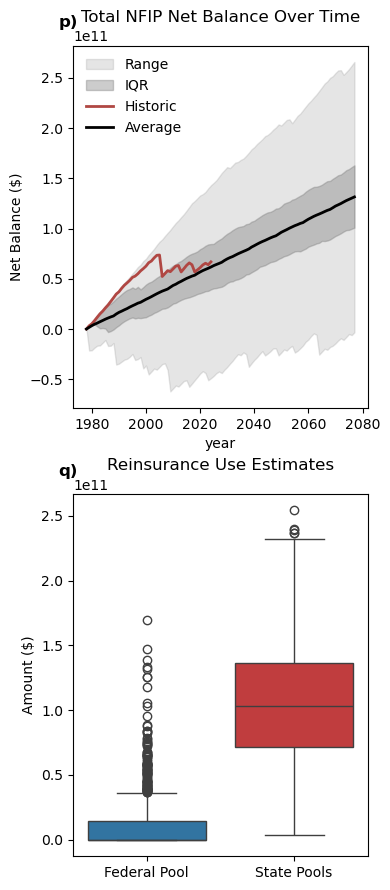

In [17]:
# ─────────────────────────────
# Prepare data for boxplot
# ─────────────────────────────
# Stack simulation outcomes for each metric
bar_df = summary[['Total_Reinsurance_Used', 'Total_Negative_Balance']].copy()
bar_df = bar_df.rename(columns={
    'Total_Reinsurance_Used': 'Federal Pool',
    'Total_Negative_Balance': 'State Pools'
})

# Melt into long format
bar_long = bar_df.melt(var_name="Pool", value_name="Amount")

# ─────────────────────────────
# Plotting
# ─────────────────────────────
fig, axs = plt.subplots(2, 1, figsize=(4, 9), sharex=False)
panel_labels = ['p)', 'q)']
label_offset = (-0.05, 1.05)

# --- Panel p: Time Series with min–max shading and mean line ---
ax = axs[0]
ax.fill_between(
    stats_by_year['year'],
    stats_by_year['min'],
    stats_by_year['max'],
    alpha=0.2,
    color='gray',
    label='Range'
)

ax.fill_between(
    stats_by_year['year'],
    stats_by_year['q25'],
    stats_by_year['q75'],
    alpha=0.4,
    color='gray',
    label='IQR'
)

sns.lineplot(
    data=time_series_df_hist,
    x="year", y="total_balance", legend=False, ax=axs[0], color='#B04743',
    lw=2, label='Historic'
)
sns.lineplot(
    data=stats_by_year, x='year', y='mean',
    ax=ax, color='black', lw=2, label='Average'
)
ax.set_title("Total NFIP Net Balance Over Time")
ax.set_ylabel("Net Balance ($)")
ax.text(label_offset[0], label_offset[1], panel_labels[0], transform=ax.transAxes,
        fontsize=12, fontweight='bold')
ax.legend(frameon=False)

# --- Panel q: Boxplots across simulations ---
sns.boxplot(
    data=bar_long,
    x="Pool", y="Amount",
    ax=axs[1],
    palette={"Federal Pool": "tab:blue", "State Pools": "tab:red"}
)

axs[1].set_title("Reinsurance Use Estimates")
axs[1].set_ylabel("Amount ($)")
axs[1].set_xlabel("")

axs[1].text(label_offset[0], label_offset[1], panel_labels[1], transform=axs[1].transAxes,
            fontsize=12, fontweight='bold')

plt.tight_layout()
if save:
    plt.savefig(f"Plots/New/NFIP_Summary_Facets_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

## Timeseries of State Pools

In [18]:
# Abbreviation mapping (if needed)
state_abbrev = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO',
    '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI',
    '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY',
    '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN',
    '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
    '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH',
    '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD',
    '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA',
    '54': 'WV', '55': 'WI', '56': 'WY'
}

# Selected state abbreviations
selected_states = ['LA', 'MS', 'ND', 'TX', 'NY', 'NJ', 'MO', 'OK', 'WV', 'IL', 'KS', 'KY', 'FL', 'MI', 'CA']

# If state_balance_df is already a DataFrame:
state_year_df_hist = state_balance_df_hist.copy()

# Normalize STATEFP to zero-padded 2-char strings
state_year_df_hist["STATEFP"] = state_year_df_hist["STATEFP"].astype(str).str.extract(r"(\d+)", expand=False).str.zfill(2)

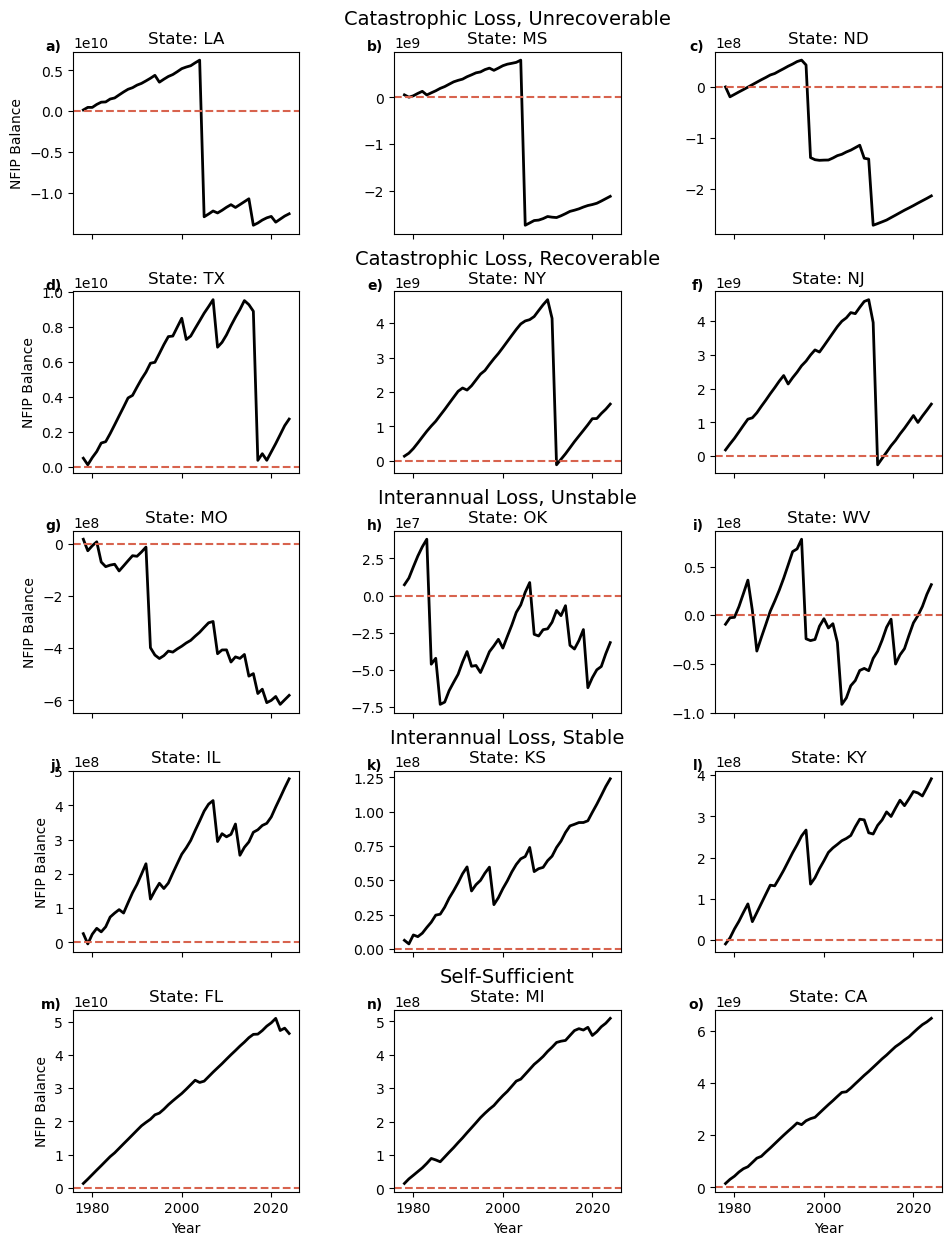

In [19]:
# Add abbreviation column
state_year_df_hist["State"] = state_year_df_hist["STATEFP"].map(state_abbrev)

# Filter to selected states
filtered_df_hist = state_year_df_hist[state_year_df_hist["State"].isin(selected_states)].copy()

# Group by state and year across simulations, compute mean balance
state_balance_by_year_hist = (
    filtered_df_hist
    .groupby(["State", "year"])["contribution"]
    .sum()
    .groupby(level=0).cumsum()  # Cumulative NFIP balance by year
    .reset_index()
    .rename(columns={"contribution": "nfip_balance"})
)

# Prepare subplots
n_states = len(selected_states)
n_cols = 3
n_rows = -(-n_states // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2.5 * n_rows), sharex=True, sharey=False)
axes = axes.flatten()

for i, state in enumerate(selected_states):
    ax = axes[i]
    df_sub = state_balance_by_year_hist[state_balance_by_year_hist["State"] == state]
    ax.plot(df_sub["year"], df_sub["nfip_balance"], color='black', linewidth=2)
    ax.axhline(0, color='#D8634E', linestyle='--')
    ax.set_title(f"State: {state}")

    # Subpanel label
    panel_label = f"{chr(97 + i)})"
    ax.text(-0.05, 1.07, panel_label,
            transform=ax.transAxes,
            fontsize=10,
            fontweight='bold',
            va='top',
            ha='right')

    row_idx = i // n_cols
    col_idx = i % n_cols
    if row_idx == n_rows - 1:
        ax.set_xlabel("Year")
    else:
        ax.set_xlabel("")

    if col_idx == 0:
        ax.set_ylabel("NFIP Balance")
    else:
        ax.set_ylabel("")

# Optional row titles (adjust as needed)
row_titles = [
    "Catastrophic Loss, Unrecoverable",
    "Catastrophic Loss, Recoverable",
    "Interannual Loss, Unstable",
    "Interannual Loss, Stable",
    "Self-Sufficient"
]

for row_idx in range(n_rows):
    mid_col_idx = row_idx * n_cols + 1
    if mid_col_idx < len(axes):
        ax = axes[mid_col_idx]
        ax.annotate(
            row_titles[row_idx],
            xy=(0.5, 1.13),
            xycoords='axes fraction',
            ha='center',
            va='bottom',
            fontsize=14
        )

plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0.05, 0, 1, 1])
if save:
    plt.savefig(f"Plots/New/SI/Balance_Timeseries_Historic.png", dpi=500, bbox_inches='tight')
plt.show()

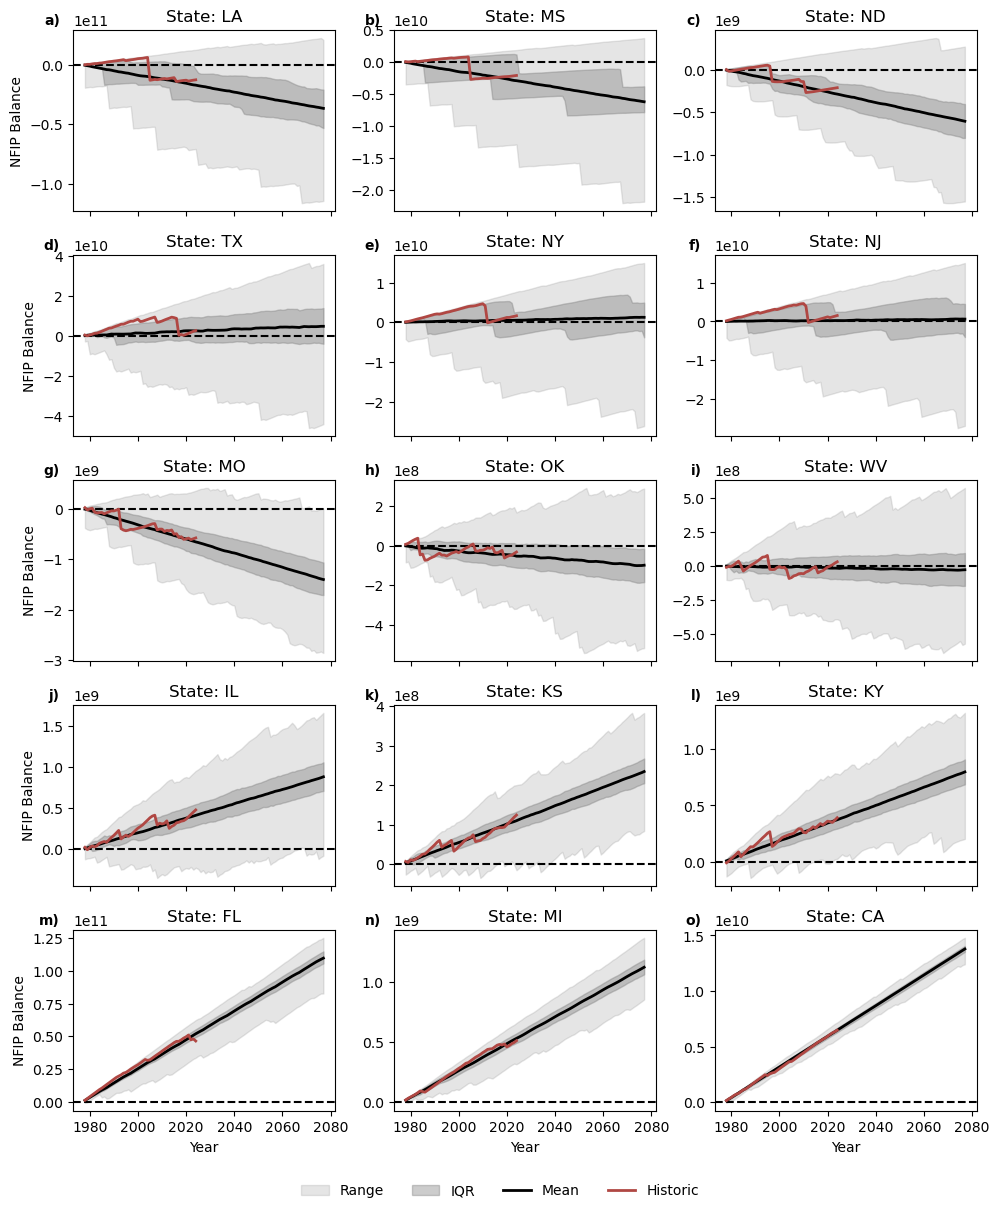

In [20]:
selected_states = ['LA', 'MS', 'ND', 'TX', 'NY', 'NJ', 'MO', 'OK', 'WV', 'IL', 'KS', 'KY', 'FL', 'MI', 'CA'] #IA (-), MN (+), PA (+), AL (-)

# If state_balance_df is already a DataFrame:
state_year_df = state_balance_df.copy()

# Normalize STATEFP to zero-padded 2-char strings
state_year_df["STATEFP"] = state_year_df["STATEFP"].astype(str).str.extract(r"(\d+)", expand=False).str.zfill(2)

# ─────────────────────────────
# Compute stats across simulations for each state and year
# ─────────────────────────────
state_year_df["cumulative_balance"] = (
    state_year_df
    .groupby(["simulation", "STATEFP"])["contribution"]
    .cumsum()
)

# Add abbreviation
state_year_df["State"] = state_year_df["STATEFP"].map(state_abbrev)

# Filter to selected states
filtered_df = state_year_df[state_year_df["State"].isin(selected_states)].copy()

# Aggregate across simulations: min, max, mean, IQR
state_balance_stats = (
    filtered_df
    .groupby(["State", "year"])["cumulative_balance"]
    .agg(
        min="min",
        max="max",
        mean="mean",
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75),
    )
    .reset_index()
)

# ─────────────────────────────
# Plotting
# ─────────────────────────────
n_states = len(selected_states)
n_cols = 3
n_rows = -(-n_states // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2.5 * n_rows), sharex=True, sharey=False)
axes = axes.flatten()

for i, state in enumerate(selected_states):
    ax = axes[i]
    df_sub = state_balance_stats[state_balance_stats["State"] == state]

    # Light shading for full range
    ax.fill_between(
        df_sub["year"], df_sub["min"], df_sub["max"],
        color="gray", alpha=0.2, label="Range"
    )

    # Darker shading for IQR (25–75th percentiles)
    ax.fill_between(
        df_sub["year"],
        df_sub["q25"],
        df_sub["q75"],
        color="gray", alpha=0.4, label="IQR"
    )

    # Mean line
    ax.plot(df_sub["year"], df_sub["mean"], color="black", linewidth=2, label="Mean")

    # Zero line
    ax.axhline(0, color='black', linestyle='--')

    df_sub_hist = state_balance_by_year_hist[state_balance_by_year_hist["State"] == state]
    ax.plot(df_sub_hist["year"], df_sub_hist["nfip_balance"], color='#B04743', linewidth=2, label='Historic')

    ax.set_title(f"State: {state}")

    # Subpanel label
    panel_label = f"{chr(97 + i)})"
    ax.text(-0.05, 1.09, panel_label,
            transform=ax.transAxes,
            fontsize=10,
            fontweight='bold',
            va='top',
            ha='right')

    row_idx = i // n_cols
    col_idx = i % n_cols
    if row_idx == n_rows - 1:
        ax.set_xlabel("Year")
    else:
        ax.set_xlabel("")

    if col_idx == 0:
        ax.set_ylabel("NFIP Balance")
    else:
        ax.set_ylabel("")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, frameon=False)

plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # bottom = 0.03 leaves more room
if save:
    plt.savefig(f"Plots/New/Balance_Timeseries_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_566/2315688105.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_balances.groupby("State").apply(pick_simulations).to_dict()


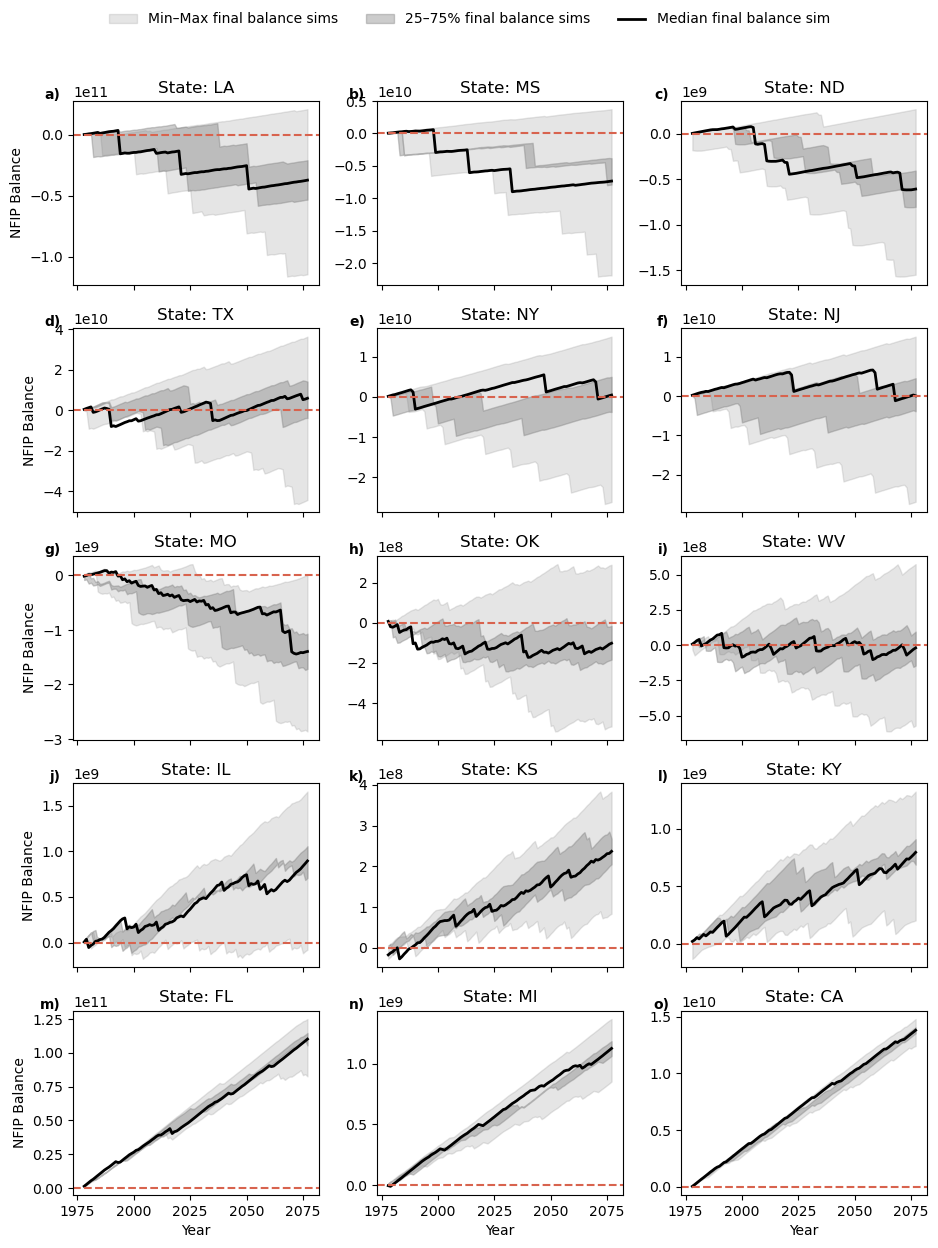

In [21]:
# ─────────────────────────────
# Identify simulations by final balance
# ─────────────────────────────
# Compute cumulative balance per sim
state_year_df["cumulative_balance"] = (
    state_year_df
    .groupby(["simulation", "STATEFP"])["contribution"]
    .cumsum()
)

# Add abbreviation
state_year_df["State"] = state_year_df["STATEFP"].map(state_abbrev)

# Filter to selected states
filtered_df = state_year_df[state_year_df["State"].isin(selected_states)].copy()

# Get final year balances for each sim/state
final_balances = (
    filtered_df.groupby(["State", "simulation"])["cumulative_balance"]
    .last()
    .reset_index()
)

# For each state, find the simulations for min, max, 25th, 75th, median
def pick_simulations(df):
    sims = {}
    vals = df["cumulative_balance"].sort_values().reset_index(drop=True)
    q25, q75 = vals.quantile([0.25, 0.75])
    median = vals.median()

    # find closest simulation to each stat
    sims["min_id"] = df.loc[df["cumulative_balance"].idxmin(), "simulation"]
    sims["max_id"] = df.loc[df["cumulative_balance"].idxmax(), "simulation"]
    sims["q25_id"] = df.iloc[(df["cumulative_balance"]-q25).abs().argmin()]["simulation"]
    sims["q75_id"] = df.iloc[(df["cumulative_balance"]-q75).abs().argmin()]["simulation"]
    sims["median_id"] = df.iloc[(df["cumulative_balance"]-median).abs().argmin()]["simulation"]
    return sims

simulations_by_state = (
    final_balances.groupby("State").apply(pick_simulations).to_dict()
)

# ─────────────────────────────
# Plotting
# ─────────────────────────────
n_states = len(selected_states)
n_cols = 3
n_rows = -(-n_states // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2.5 * n_rows), sharex=True, sharey=False)
axes = axes.flatten()

for i, state in enumerate(selected_states):
    ax = axes[i]
    sims = simulations_by_state[state]

    # Subset data for chosen simulations
    df_state = filtered_df[filtered_df["State"] == state]

    df_min = df_state[df_state["simulation"] == sims["min_id"]]
    df_max = df_state[df_state["simulation"] == sims["max_id"]]
    df_q25 = df_state[df_state["simulation"] == sims["q25_id"]]
    df_q75 = df_state[df_state["simulation"] == sims["q75_id"]]
    df_median = df_state[df_state["simulation"] == sims["median_id"]]

    # Light shading: min–max sims
    ax.fill_between(
        df_min["year"], df_min["cumulative_balance"], df_max["cumulative_balance"],
        color="gray", alpha=0.2, label="Min–Max final balance sims"
    )

    # Darker shading: 25th–75th sims
    ax.fill_between(
        df_q25["year"], df_q25["cumulative_balance"], df_q75["cumulative_balance"],
        color="gray", alpha=0.4, label="25–75% final balance sims"
    )

    # Median line
    ax.plot(df_median["year"], df_median["cumulative_balance"],
            color="black", linewidth=2, label="Median final balance sim")

    # Zero line
    ax.axhline(0, color='#D8634E', linestyle='--')

    ax.set_title(f"State: {state}")

    # Subpanel label
    panel_label = f"{chr(97 + i)})"
    ax.text(-0.05, 1.07, panel_label,
            transform=ax.transAxes,
            fontsize=10,
            fontweight='bold',
            va='top',
            ha='right')

    row_idx = i // n_cols
    col_idx = i % n_cols
    if row_idx == n_rows - 1:
        ax.set_xlabel("Year")
    else:
        ax.set_xlabel("")

    if col_idx == 0:
        ax.set_ylabel("NFIP Balance")
    else:
        ax.set_ylabel("")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)

plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0.05, 0, 1, 0.95])
if save:
    plt.savefig(f"Plots/New/SI/Balance_Timeseries_Percentile_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

## Debt Accum by State

In [22]:
def custom_stackplot(ax, df, title, ylabel, xlabel, label_text, label_pos, colors_dict):
    if df is None or df.empty or df.shape[1] == 0:
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.text(label_pos[0], label_pos[1], label_text, transform=ax.transAxes,
                ha='left', va='top', fontsize=12, fontweight='bold')
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha='center', va='center', fontsize=11)
        return

    # Use the columns of THIS df, not a global list
    cols = list(df.columns)

    # Build a color list that matches the number of series exactly
    cmap_local = cm.get_cmap("Spectral", len(cols))
    if colors_dict is None:
        color_list = [cmap_local(i) for i in range(len(cols))]
    else:
        color_list = [colors_dict.get(c, cmap_local(i)) for i, c in enumerate(cols)]

    x = df.index
    y = [df[c].values for c in cols]

    # Unpack series with *y
    ax.stackplot(x, *y, labels=cols, colors=color_list, linewidth=0)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.text(label_pos[0], label_pos[1], label_text, transform=ax.transAxes,
            ha='left', va='top', fontsize=12, fontweight='bold')

In [23]:
# Simulated structure from previous pipeline
df = state_year_df.copy()
df["State"] = df["STATEFP"].map({
    '22': 'LA', '28': 'MS', '38': 'ND', '48': 'TX', '36': 'NY', '34': 'NJ',
    '29': 'MO', '40': 'OK', '54': 'WV', '17': 'IL', '20': 'KS', '21': 'KY',
    '12': 'FL', '26': 'MI', '06': 'CA'
})

# Filter to selected states
selected_states = ['LA', 'MS', 'ND', 'TX', 'NY', 'NJ', 'MO', 'OK', 'WV', 'IL', 'KS', 'KY', 'FL', 'MI', 'CA']
df = df[df["State"].isin(selected_states)]

# Add cumulative and yearly balance tracking
df["nfip_balance"] = df.groupby(["simulation", "State"])["contribution"].cumsum()
df["yearly_debt"] = df["contribution"]  # Negative contributions = debt

# Filter to negative balance years only
neg_df = df[df["nfip_balance"] < 0]

# Pivot for plotting
pivot_df = (
    neg_df.groupby(["year", "State"])["nfip_balance"]
    .mean()
    .unstack(fill_value=0)
)

# Normalize by premium
premium_df = (
    df.groupby("State")["premium"]
    .mean()
    .replace(0, np.nan)
)

# Compute year-over-year added deficit
delta_neg_billion = pivot_df.diff().clip(upper=0).abs() / 1e9
pivot_df_billion = pivot_df / 1e9

# Clean normalization: replace inf/NaN from zero/NaN premiums
normalized_pivot_df = (
    pivot_df
    .divide(premium_df, axis=1)
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
)

# Normalize YOY added deficit (after cleaning)
delta_norm = (
    normalized_pivot_df
    .diff()
    .clip(upper=0)
    .abs()
)

# Ensure year index is numeric and sorted
for _df in [pivot_df, normalized_pivot_df, delta_neg_billion, pivot_df_billion, delta_norm]:
    _df.index = pd.to_numeric(_df.index, errors='coerce')
    _df.sort_index(inplace=True)

# Build colors dict from the union of all columns you might plot
all_cols = sorted(set(pivot_df.columns) |
                  set(normalized_pivot_df.columns) |
                  set(delta_neg_billion.columns) |
                  set(delta_norm.columns))
cmap = cm.get_cmap("Spectral", max(len(all_cols), 1))
colors_dict = {s: cmap(i) for i, s in enumerate(all_cols)}
colors_dict['ND'] = (1.0, 0.973, 0.676, 1.0)  # optional override

/tmp/ipykernel_566/2554226590.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral", max(len(all_cols), 1))


/tmp/ipykernel_566/1191005492.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral", len(states_all) or 1)
/tmp/ipykernel_566/48924325.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_local = cm.get_cmap("Spectral", len(cols))


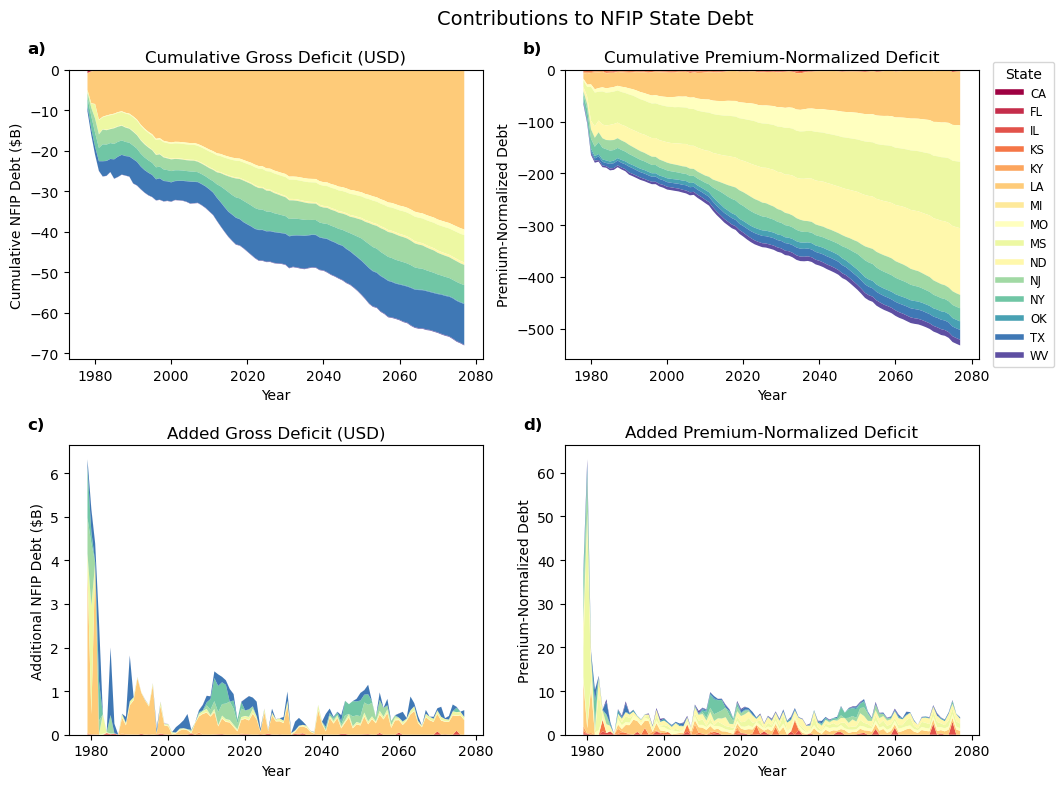

In [24]:
# Build a colors dict once (optional)
states_all = sorted(pivot_df.columns)  # from the first df you plotted
cmap = cm.get_cmap("Spectral", len(states_all) or 1)
colors_dict = {s: cmap(i) for i, s in enumerate(states_all)}
colors_dict['ND'] = (1.0, 0.973, 0.676, 1.0)  # custom override

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Contributions to NFIP State Debt", fontsize=14)

panel_labels = ['a)', 'b)', 'c)', 'd)']
label_offset = (-0.1, 1.1)

custom_stackplot(axs[0, 0], pivot_df_billion, "Cumulative Gross Deficit (USD)",
                 "Cumulative NFIP Debt ($B)", "Year", panel_labels[0], label_offset, colors_dict)
custom_stackplot(axs[0, 1], normalized_pivot_df, "Cumulative Premium-Normalized Deficit",
                 "Premium-Normalized Debt", "Year", panel_labels[1], label_offset, colors_dict)
custom_stackplot(axs[1, 0], delta_neg_billion, "Added Gross Deficit (USD)",
                 "Additional NFIP Debt ($B)", "Year", panel_labels[2], label_offset, colors_dict)
custom_stackplot(axs[1, 1], delta_norm, "Added Premium-Normalized Deficit",
                 "Premium-Normalized Debt", "Year", panel_labels[3], label_offset, colors_dict)

legend_states = list(pivot_df.columns)  # or any df you want the legend for
handles = [plt.Line2D([0], [0], color=colors_dict[s], lw=4) for s in legend_states]
axs[0, 1].legend(handles, legend_states, loc='center left', bbox_to_anchor=(1.02, 0.5),
                 title="State", fontsize='small', title_fontsize='medium')

plt.tight_layout()
plt.subplots_adjust(right=0.82)
if save:
    plt.savefig(f"Plots/New/State_Debt_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

## Relative Hyperclusters

In [25]:
# Step 1: Filter to years after 1987 (10 years)
post_initial_period = balance_transition_df[balance_transition_df["year"] > 1987]

# Step 2: Count how many simulations each cluster appears in
cluster_sim_counts = (
    post_initial_period
    .groupby("top_cluster")["simulation"]
    .nunique()
)

# Step 3: Filter to only clusters that appear in at least 20 simulations
if test_case == "historic":
    frequent_clusters = cluster_sim_counts[cluster_sim_counts >= 1].index
else:
    num_thres = simulations*0.2
    frequent_clusters = cluster_sim_counts[cluster_sim_counts >= num_thres].index

# Step 4: Convert to set
events = set(frequent_clusters)

# Step 1: Define known cluster mapping
cluster_event_map = {
    511: "1978 Summer Flash Floods",
    17: "Hurricane Frederic", # 1979
    231: "1979 Midwest Floods",
    27: "1979 Easter Flood",
    393: "1979 Grand Forks Floods",
    60: "1982 Meramec Flood",
    278: "1984 May Floods",
    5115: "1984 Tulsa Memorial Day Flood",
    65: "1986 Oklahoma Floods",
    367: "1985 Election Day Floods",
    203: "Great Flood of 1993",
    218: "1994 Meramec Flood",
    342: "1995 NOLA Floods",
    157: "Hurricane Fran", # 1996
    137: "1996 Northeast Floods",
    236: "1997 Red River Flood",
    56: "1997 Ohio River Valley Flood",
    268: "1998 Townsville Floods",
    7: "Hurricane Georges", # 1998
    312: "Tropical Storm Allison", # 2001
    147: "Hurricane Isabel", # 2003
    6: "Hurricane Ivan", # 2004
    4: "Hurricane Katrina", # 2005
    153: "2006 Northeast Floods",
    8: "Hurricane Ike", # 2008
    267: "2007 TX/OK Floods",
    199: "2008 Midwest Floods",
    391: "2009 Red River Flood",
    2279: "2010 Central Iowa Floods",
    33: "2010 TN Floods",
    35: "2011 Mississippi River Floods",
    4826: "2011 Souris River Flood",
    5602: "2011 Missouri River Flood",
    91: "Hurricane Irene", # 2011
    131: "Tropical Storm Lee", # 2011
    87: "Hurricane Sandy", # 2012
    54: "2015 Ozarks Flood",
    64: "2015 TX/OK Flood and Tornadoes",
    295: "2016 Louisiana Floods",
    168: "Hurricane Matthew",
    500: "2016 West Virginia Downpour",
    49: "2017 Midwest Floods",
    327: "Hurricane Harvey", # 2017
    376: "Hurricane Florence", # 2018
    63: "2019 Arkansas River Floods",
    5587: "2019 SD Flash Floods",
    263: "2019 Midwest Floods",
    1: "Hurricane Sally", # 2020
    166: "Hurricane Ian", # 2022
    3723: "2022 St. Louis Flash Flood",
    95: "2023 Northeast Floods",
    190: "Hurricane Helene", # 2024
}

print(f'{len(events)} Imbalancing events:{events}')

20 Imbalancing events:{131.0, 4.0, 6.0, 8.0, 137.0, 267.0, 33.0, 63.0, 64.0, 199.0, 327.0, 203.0, 87.0, 4826.0, 91.0, 5602.0, 236.0, 367.0, 500.0, 5115.0}


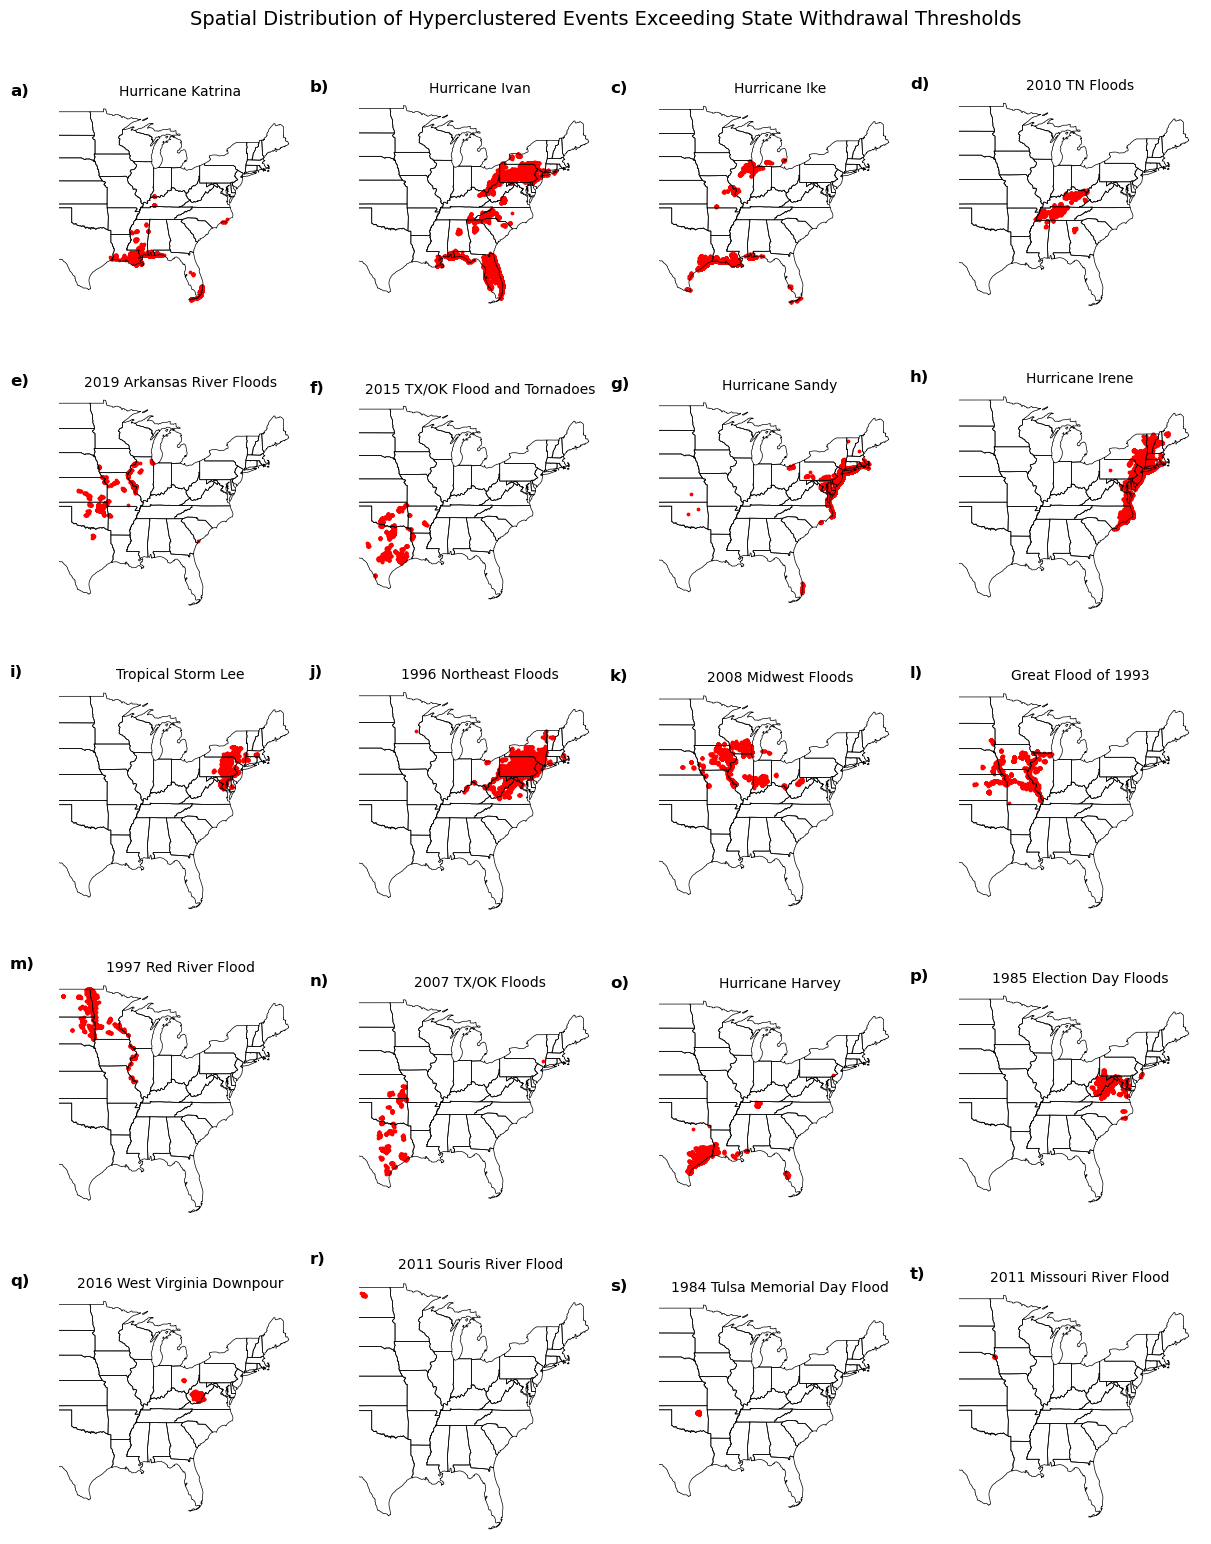

In [26]:
# Convert events to sorted list for consistent ordering
event_list = sorted(events)

# Set spatial extent for consistency
extent = [-102, -65, 24, 50]

# Adjust grid if more events are needed
n_panels = len(event_list)
ncols = 4
nrows = int(np.ceil(n_panels / ncols))

label_offset = (-0.2, 1.1)

# Prepare figure
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3 * nrows), constrained_layout=True)
axs = axs.flatten()
panel_labels = [f"{chr(97 + i)})" for i in range(len(axs))]

for i, cluster_id in enumerate(event_list):
    ax = axs[i]

    # Determine name or fallback label
    event_name = cluster_event_map.get(cluster_id, f"Cluster {cluster_id}")

    # Filter points for this cluster
    cluster_points = clustered_claims[clustered_claims[optimal_cluster] == cluster_id]

    # GeoDataFrame for plotting
    gdf_claims_all = gpd.GeoDataFrame(
        cluster_points,
        geometry=gpd.points_from_xy(cluster_points['longitude'], cluster_points['latitude']),
        crs="EPSG:4326"
    )

    # Plot boundaries and points
    gdf_states.boundary.plot(ax=ax, color='black', linewidth=0.5)
    gdf_claims_all.plot(ax=ax, color='red', markersize=3)

    # Format plot
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_title(event_name, fontsize=10)
    ax.axis("off")

    # Panel label
    ax.text(label_offset[0], label_offset[1], panel_labels[i], transform=ax.transAxes,
            ha='left', va='top', fontsize=12, fontweight='bold')

# Turn off any extra axes
for j in range(len(event_list), len(axs)):
    axs[j].axis("off")

plt.suptitle("Spatial Distribution of Hyperclustered Events Exceeding State Withdrawal Thresholds", fontsize=14, y=1.03)
if save:
    plt.savefig(f"Plots/New/Clusters_Space_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

## Extreme Loss vs Underpricing Risk

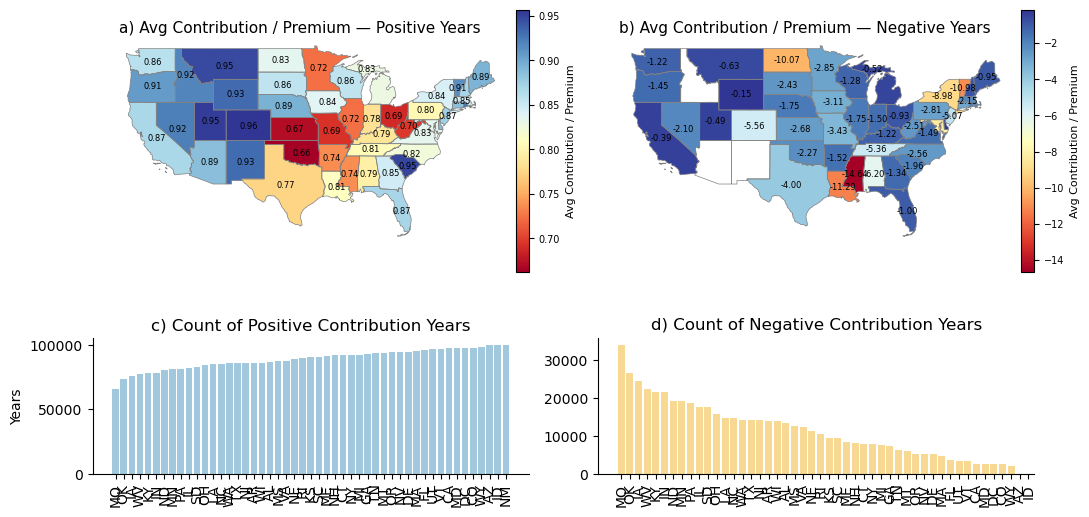

In [27]:
# ── Step 1: Create category flags ──
state_balance_df["is_positive"] = state_balance_df["contribution"] > 0
state_balance_df["is_negative"] = state_balance_df["contribution"] < 0
state_balance_df["contribution_ratio"] = state_balance_df["contribution"] / state_balance_df["premium"]
state_balance_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# ── Step 2: Group by STATEFP and calculate averages ──
def average_ratio(df, flag_col, flag_val, label):
    return (
        df[df[flag_col] == flag_val]
        .groupby("STATEFP")["contribution_ratio"]
        .mean()
        .reset_index()
        .rename(columns={"contribution_ratio": label})
    )

avg_positive = average_ratio(state_balance_df, "is_positive", True, "Avg_Pos")
avg_negative = average_ratio(state_balance_df, "is_negative", True, "Avg_Neg")

# ── Step 3: Count years and join STUSPS ──
state_lookup = gdf_states[["STATEFP", "STUSPS"]]

count_positive = (
    state_balance_df[state_balance_df["is_positive"]]
    .groupby("STATEFP")
    .size()
    .reset_index(name="Positive_Years")
    .merge(state_lookup, on="STATEFP")
)

count_negative = (
    state_balance_df[state_balance_df["is_negative"]]
    .groupby("STATEFP")
    .size()
    .reset_index(name="Negative_Years")
    .merge(state_lookup, on="STATEFP")
)

# Match ordering for both plots
plot_order = count_positive["STUSPS"].tolist()
count_negative = count_negative[count_negative["STUSPS"].isin(plot_order)]
count_negative = count_negative.set_index("STUSPS").reindex(plot_order).reset_index()

# Safely reindex both to same order
sort_order = count_positive.sort_values("Positive_Years")["STUSPS"]

# Reindex both with sorted STUSPS
count_positive = count_positive.set_index("STUSPS").reindex(sort_order).reset_index()
count_negative = count_negative.set_index("STUSPS").reindex(sort_order).reset_index()

# ── Step 4: Merge choropleth data into GeoDataFrame ──
gdf_plot = gdf_states.copy()
for df in [avg_positive, avg_negative]:
    gdf_plot = gdf_plot.merge(df, on="STATEFP", how="left")

# ── Step 5: Plot configuration ──
fig = plt.figure(figsize=(11, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])  # top taller, bottom shorter

axs = [
    fig.add_subplot(gs[0, 0]),  # a) Map
    fig.add_subplot(gs[0, 1]),  # b) Map
    fig.add_subplot(gs[1, 0]),  # c) Bar
    fig.add_subplot(gs[1, 1]),  # d) Bar
]

extent = [-130, -65, 24, 50]
x_min, x_max, y_min, y_max = extent
skip_labels = {"DC", "RI", "CT", "DE", "MD", "NH"}
cmap = "RdYlBu"

# ── Panels a & b: Choropleths ──
choropleth_configs = [
    ("Avg_Pos", "a) Avg Contribution / Premium — Positive Years"),
    ("Avg_Neg", "b) Avg Contribution / Premium — Negative Years"),
]

for ax, (col, title) in zip(axs[:2], choropleth_configs):
    vmin = gdf_plot[col].min()
    vmax = gdf_plot[col].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    gdf_plot.plot(column=col, cmap=cmap, linewidth=0.1, ax=ax, norm=norm, legend=False)
    gdf_plot.boundary.plot(ax=ax, color="grey", linewidth=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.axis("off")
    ax.set_title(title, fontsize=11)

    for _, row in gdf_plot.iterrows():
        abbr = row["STUSPS"]
        rep_point = row.geometry.representative_point()
        x, y = rep_point.x, rep_point.y
        val = row[col]
        if abbr in skip_labels or np.isnan(val):
            continue
        ax.text(x, y, f"{val:.2f}", ha='center', va='center', fontsize=6, color='black')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label("Avg Contribution / Premium", fontsize=8)
    cbar.ax.tick_params(labelsize=7)

# ── Panels c & d: Vertical bar charts with shared x-axis ──
axs[2].bar(count_positive["STUSPS"], count_positive["Positive_Years"], color="#A1C8DD")
axs[2].set_title("c) Count of Positive Contribution Years")
axs[2].tick_params(axis='x', rotation=90)
if test_case == 'historic':
    axs[2].set_ylim([0,47])
axs[2].spines[['top', 'right']].set_visible(False)
axs[2].set_ylabel("Years")

axs[3].bar(count_negative["STUSPS"], count_negative["Negative_Years"], color="#F8D994")
axs[3].set_title("d) Count of Negative Contribution Years")
axs[3].tick_params(axis='x', rotation=90)
axs[3].spines[['top', 'right']].set_visible(False)
if test_case == 'historic':
    axs[3].set_ylim([0,47])


# ── Final layout ──
plt.tight_layout()
if save:
    plt.savefig(f"Plots/New/Contribution_MapsAndBars_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

# Benefit and Strain

In [28]:
# Sum reinsurance used and final balance per state
re_summary = (
    cluster_state_df.groupby("STATEFP")[["re_covered"]]
    .sum()
    .reset_index()
)

balance_summary = (
    final_balances_df.groupby("STATEFP")[["nfip_balance"]]
    .mean()  # or .last() if only using final year
    .reset_index()
)

premium_summary = (
    gdf_states[["STATEFP", "Total Written Premium + FPF"]]
    .rename(columns={"Total Written Premium + FPF": "premium"})
)

# Merge all together
summary_df = (
    re_summary
    .merge(balance_summary, on="STATEFP", how="outer")
    .merge(premium_summary, on="STATEFP", how="left")
)

# Drop states with zero or missing premium
summary_df = summary_df[summary_df["premium"] > 0].copy()
summary_df["premium"] = summary_df["premium"].replace(0, np.nan)

# --- Derived Metrics ---
summary_df["Norm_re"] = summary_df["re_covered"] / summary_df["premium"]
summary_df["Norm_balance"] = summary_df["nfip_balance"] / summary_df["premium"]

# System-wide benefit
total_balance = summary_df["nfip_balance"].sum()
total_premiums = summary_df["premium"].sum()
epsilon = 0.1

summary_df["Net_benefit"] = total_balance / summary_df["nfip_balance"].clip(lower=epsilon)
summary_df["Original_benefit"] = total_premiums / summary_df["premium"]
summary_df["Norm_strain"] = (summary_df["Net_benefit"] - summary_df["Original_benefit"]) / summary_df["Net_benefit"]

# Merge back to gdf_states for plotting
gdf_plot = gdf_states.merge(summary_df, on="STATEFP", how="left")

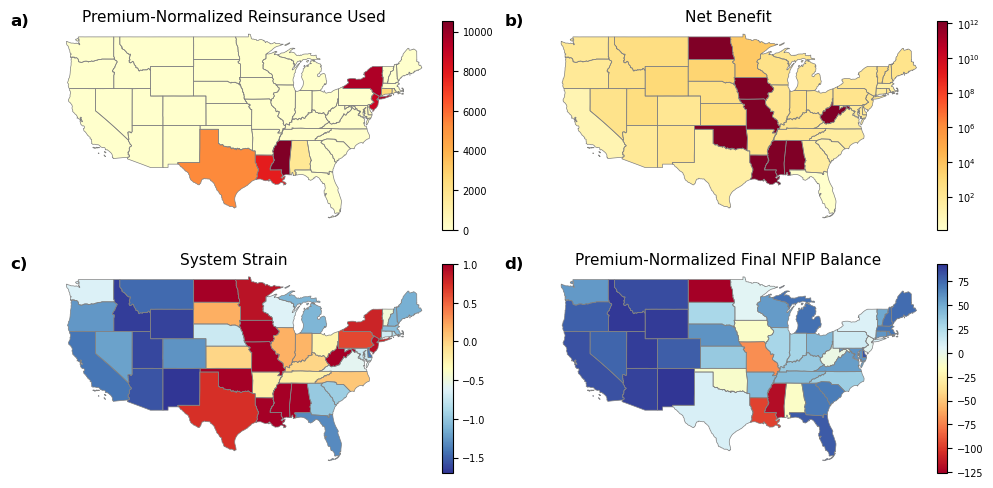

In [29]:
# Panel metadata
plot_data = [
    ("Norm_re", "Premium-Normalized Reinsurance Used", "a)", lambda v: f"{v:.1f}", "YlOrRd", None, ""),
    ("Net_benefit", "Net Benefit", "b)", lambda v: f"1e{int(np.round(np.log10(v)))}" if v > 0 else "0", "YlOrRd",
     LogNorm(vmin=gdf_plot["Net_benefit"].replace(0, np.nan).min(), vmax=gdf_plot["Net_benefit"].max()), ""),
    ("Norm_strain", "System Strain", "c)", lambda v: f"{v:.1f}", "RdYlBu_r", None, ""),
    ("Norm_balance", "Premium-Normalized Final NFIP Balance", "d)", lambda v: f"{v:.0f}", "RdYlBu", None, ""),
]

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
extent = [-130, -65, 24, 50]
x_min, x_max, y_min, y_max = extent
skip_labels = {"DC", "RI", "CT", "DE", "MD", "NH"}

for i, (ax, (col, title, label, fmt_fn, cmap, norm, cbar_label)) in enumerate(zip(axs.flat, plot_data)):
    gdf_plot.plot(
        column=col, cmap=cmap, linewidth=0.1, ax=ax,
        norm=norm, legend=False
    )
    gdf_plot.boundary.plot(ax=ax, color="grey", linewidth=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.axis("off")
    ax.set_title(title, fontsize=11)

    #if i in [2, 3]:
    """
    for idx, row in gdf_plot.iterrows():
        abbr = row["STUSPS"]
        rep_point = row.geometry.representative_point()
        x, y = rep_point.x, rep_point.y
        val = row[col]
        if abbr in skip_labels or np.isnan(val):
            continue
        ax.text(x, y, fmt_fn(val), ha='center', va='center', fontsize=6, color='black')
    """
    
    ax.text(-0.06, 1.02, label, transform=ax.transAxes, size=12, weight='bold')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm if norm else plt.Normalize(
        vmin=gdf_plot[col].min(), vmax=gdf_plot[col].max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label(cbar_label, fontsize=8)
    cbar.ax.tick_params(labelsize=7)

plt.tight_layout()
if save:
    plt.savefig(f"Plots/New/Strain_Reinsurance4_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()